# **Flan-t5 Model**
This notebook uses Google Flan-t5, fine-tuned with Low Rank Adaptation (LoRA) and LangChain framework, to perform sentiment analysis on our dataset, thereby predicting stock price trends.

In [1]:
!pip install -U langchain langchain-community
!pip install datasets
!pip install accelerate
!pip install --upgrade transformers
!git clone https://github.com/CKZ1107/COMP6713-NLP.git
%cd COMP6713-NLP

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, TrainingArguments, Trainer, AutoModelForSeq2SeqLM
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFacePipeline
from langchain.chains import LLMChain
import json
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import torch
import accelerate
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training, PeftModel
from datasets import Dataset

from helpers.setup import *
from helpers.model import *
from helpers.evaluation import *
from helpers.dataset import get_split_datasets

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...


[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


NLTK resource download complete
CUDA device detected!


### (SHARED) Model and Dataset Parameters

In [3]:
# Model hyperparameters
max_chunk_length = 256
max_chunks = 8
batch_size = 4
num_epochs = 45
learning_rate = 2e-5
aggregation_method = 'attention'
early_stopping_patience = 6
use_wordnet = True
focal_gamma = 2.0

# dataset and dataloaders
df = pd.read_csv(dataset_path)
train_datasets, val_datasets, test_datasets = get_split_datasets(
    df, labels=label_list, use_wordnet=use_wordnet, max_chunk_length=max_chunk_length, max_chunks=max_chunks
)
_, train_df = train_datasets
_, val_df = val_datasets
_, test_df = test_datasets
num_stocks = len(df[stock].unique())

Train set: 2979 examples
Validation set: 590 examples
Test set: 615 examples

Testing WordNet enhancement...
Original: I bought my first $AAPL stock in 2010. Since then it has seen a 1,372.29% increase. Tell me again. W...
Enhanced: I bought my first $AAPL stock in 2010 . Since then it has have seen a 1,372.29% increase addition . ...

Original: Why can XPeng P5 deliver outstanding performance in extreme conditions? CEO He Xiaopeng explains the...
Enhanced: Why can tin XPeng P5 deliver outstanding performance in extreme conditions ? CEO He Xiaopeng explain...

Original: @TSM_Myth You dismantled me mentally and emotionally today [SEP] @TSM_Myth You did great! Dont be so...
Enhanced: @TSM_Myth You dismantled level me mentally and emotionally today [SEP] @TSM_Myth You did make great ...



# 1. Flan-t5 Model

In [4]:
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)

model = get_peft_model(model, lora_config)

# Tokenization
def tokenize(example):
    prompt = example["input"]
    label = example["output"]
    tokenized = tokenizer(prompt, truncation=True, padding="max_length", max_length=512)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(label, truncation=True, padding="max_length", max_length=10)
        labels["input_ids"] = [
          (label if label != tokenizer.pad_token_id else -100) for label in labels["input_ids"]
        ]
    tokenized["labels"] = [(l if l != tokenizer.pad_token_id else -100) for l in labels["input_ids"]]
    return tokenized

def convert(row):
    return {
        "input": f"Classify sentiment: {row['post']}",
        "output": str(row["label"])
    }

# Step 4: Convert and create HF Datasets
converted_train = train_df.apply(convert, axis=1).tolist()
converted_val = val_df.apply(convert, axis=1).tolist()

dataset_train = Dataset.from_list(converted_train)
dataset_val = Dataset.from_list(converted_val)

# Step 5: Tokenize using your existing tokenize function
tokenized_train = dataset_train.map(tokenize)
tokenized_val = dataset_val.map(tokenize)

print(type(tokenized_train[0]["labels"]), tokenized_train[0]["labels"])
non_empty = sum(x != -100 for x in tokenized_train[0]["labels"])
print(f"Label tokens used: {non_empty}")
'''
converted = df.apply(convert, axis=1).tolist()
dataset = Dataset.from_list(converted)
tokenized_dataset = dataset.map(tokenize)

print(type(tokenized_dataset[0]["labels"]), tokenized_dataset[0]["labels"])

for i in range(5):
    print(tokenized_dataset[i])
non_empty = sum(x != -100 for x in tokenized_dataset[0]["labels"])
print(f"Label tokens used: {non_empty}")

# Split into train/test
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_data = split_dataset["train"]
eval_data = split_dataset["test"]

print(f"Validation size: {len(eval_data)}")
'''

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/2979 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

<class 'list'> [3, 18, 12734, 1, -100, -100, -100, -100, -100, -100]
Label tokens used: 4


'\nconverted = df.apply(convert, axis=1).tolist()\ndataset = Dataset.from_list(converted)\ntokenized_dataset = dataset.map(tokenize)\n\nprint(type(tokenized_dataset[0]["labels"]), tokenized_dataset[0]["labels"])\n\nfor i in range(5):\n    print(tokenized_dataset[i])\nnon_empty = sum(x != -100 for x in tokenized_dataset[0]["labels"])\nprint(f"Label tokens used: {non_empty}")\n\n# Split into train/test\nsplit_dataset = tokenized_dataset.train_test_split(test_size=0.2)\ntrain_data = split_dataset["train"]\neval_data = split_dataset["test"]\n\nprint(f"Validation size: {len(eval_data)}")\n'

In [6]:
print("Example label string:", tokenizer.decode([x for x in tokenized_train[0]["labels"] if x != -100]))

Example label string: -1.0</s>


In [7]:
model.eval()
with torch.no_grad():
    inputs = tokenizer("Classify sentiment: The stock is rising fast", return_tensors="pt")
    labels = tokenizer("increase", return_tensors="pt")["input_ids"]
    outputs = model(**inputs, labels=labels)
    print(outputs.loss)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


tensor(7.5327)


In [9]:
# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    logging_dir="./logs",
    save_strategy="no",
    eval_strategy="no",
    output_dir="./lora-checkpoints",
    label_names=["labels"],
    fp16=True,
    load_best_model_at_end=True,
    report_to="none"
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

# Train!
trainer.train()

# Save adapter
model.save_pretrained("./lora-finetuned")
tokenizer.save_pretrained("./lora-finetuned")

base_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
model = PeftModel.from_pretrained(base_model, "./lora-finetuned")
model = model.merge_and_unload()

pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_new_tokens=512)

Step,Training Loss
500,0.000000
1000,0.000000


Device set to use cuda:0


### Prompt Template with 3D Inputs (date, stock, post)

In [10]:
llm = HuggingFacePipeline(pipeline=pipe)

In [11]:
template = """
You are a reliable and excellent financial expert who's been doing sentiment analysis on social media to capture \
its correlation with stock price trends. You are given the following social media posts (each post is separated by \
the character ' [SEP] ', ordered by the time it was created), on the same given date and stock code:

Date: {date}
Stock: {stock}
Posts: "{post}"

The first step you should do is classify the sentiment for each post.
The second step is, based on all of these posts, the given date, and the stock code, predict the stock price trend.
You are only allowed to give predictions based on data prior to the given date.
The third step is to provide your reasoning for your predictions.
Finally, with your reasoning, provide the finalized prediction of the stock price trend (either 'increase' or 'decrease').

Respond in the following JSON format:
- sentiments: ['negative' or 'positive'],
- prediction: ['increase' or 'decrease'],
- reasoning: your reasoning, 1-2 sentences long

Your answer:
"""

prompt = PromptTemplate(
    input_variables=["date", "stock", "post"],
    template=template,
)

chain = LLMChain(llm=llm, prompt=prompt)

In [22]:
def classify_with_voting(row, n_votes=3):
    predictions = []

    for i in range(n_votes):
        try:
            response = chain.invoke({
                "date": str(row[date]),
                "stock": row[stock][:450],
                "post": row[post][:512]
            })

            if "text" in response:
                #print(response)
                predictions.append(response["text"].lower())
                #print(response["text"])
            else:
                print(f"❌ Run {i+1}: Missing 'prediction' key →", response)

        except Exception as e:
            print(f"❌ Run {i+1} failed for row:\n{row}")
            print("❌ Error:", e)

    if predictions:
        # Count and return the majority prediction
        prediction_counts = Counter(predictions)
        majority = prediction_counts.most_common(1)[0][0]
        return majority
    else:
        return "unknown"

In [24]:
test_df["majority_sentiment"] = test_df.apply(classify_with_voting, axis=1)

In [25]:
def map_prediction_to_label(prediction_str):
    pred = prediction_str.strip().lower()
    if "positive" in pred:
        return 1
    elif "negative" in pred:
        return -1
    else:
        return None

Accuracy : 0.5805
F1 Score : 0.3673
Precision: 0.2946
Recall   : 0.4877


<Figure size 600x600 with 0 Axes>

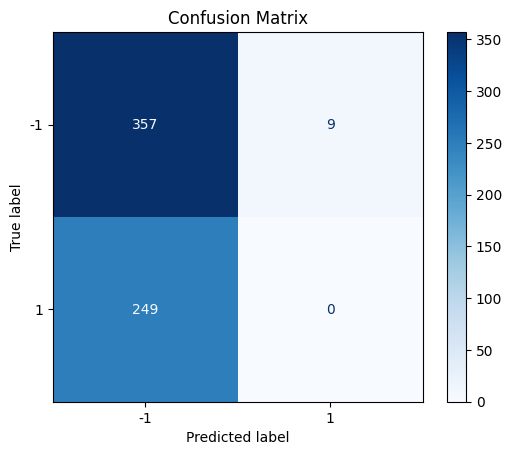

In [26]:
y_true = test_df["label"]
y_pred = test_df["majority_sentiment"].apply(map_prediction_to_label)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")

print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

labels = [-1, 1]

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()